# Compyter Vision

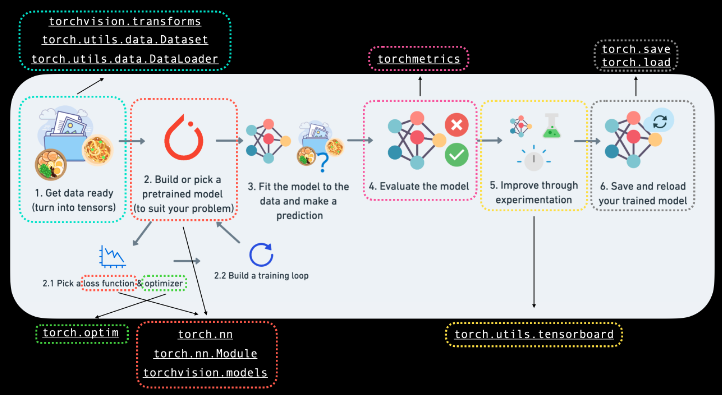

## [torchvision Module](https://pytorch.org/vision/stable/index.html)

[torchvision.datasets](https://pytorch.org/vision/stable/datasets.html)
> many example computer vision datasets for a range of problems from image classification, object detection, image captioning, video classification and more.
  - [making custom datasets](https://pytorch.org/vision/stable/datasets.html#base-classes-for-custom-datasets)

[torchvision.models](https://pytorch.org/vision/stable/models.html)
> well-performing and commonly used computer vision model architectures implemented in PyTorch

[torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)
> Often images need to be transformed (turned into numbers/processed/augmented) before being used with a model, common image transformations are found here

[torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#module-torch.utils.data)
> Creates a Python iteralbe over a dataset

# Import Module

In [1]:
# Import PyTorch
import torch
from torch import nn

from torch.utils.data import DataLoader

# Import torchvision
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

# 학습에 사용할 CPU나 GPU 장치를 얻습니다.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'device: {device}')

PyTorch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118
device: cpu


In [2]:
!pip install torchinfo

In [3]:
import torchinfo

In [4]:
import os, random
import numpy as np
import pandas as pd

SEED = 42

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)    # 파이썬 환경변수 시드 고정
    np.random.seed(seed)
    torch.manual_seed(seed) # cpu 연산 무작위 고정
    torch.cuda.manual_seed(seed) # gpu 연산 무작위 고정
    torch.backends.cudnn.deterministic = True  # cuda 라이브러리에서 Deterministic(결정론적)으로 예측하기 (예측에 대한 불확실성 제거 )

reset_seeds(SEED)

In [5]:
def eval_model(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                accuracy_fn,
                device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [6]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [7]:
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [8]:
def train_step(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                accuracy_fn,
                device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


In [9]:
def test_step(data_loader: torch.utils.data.DataLoader,
                model: torch.nn.Module,
                loss_fn: torch.nn.Module,
                accuracy_fn,
                device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")


# Data
> We're going to be using our own custom dataset of pizza, steak and sushi images.

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [11]:
train_set = torchvision.datasets.CIFAR10(
    root='./data',        # 데이터 저장 위치
    train=True,           # True: train set, False: test set
    download=True,       # 다운로드 여부, (이미 다운받았으면 False로 지정)
    transform=transform   # 데이터 선처리 작업
)

test_set = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 170498071/170498071 [00:02<00:00, 67686276.55it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [12]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" # data/pizza_steak_sushi

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [13]:
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


In [14]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.


In [15]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Visualize an image

Random image path: data/pizza_steak_sushi/train/sushi/1221830.jpg
Image class: sushi
Image height: 512
Image width: 512


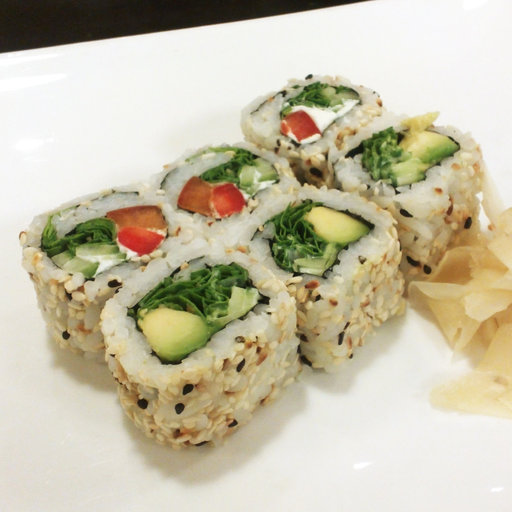

In [16]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

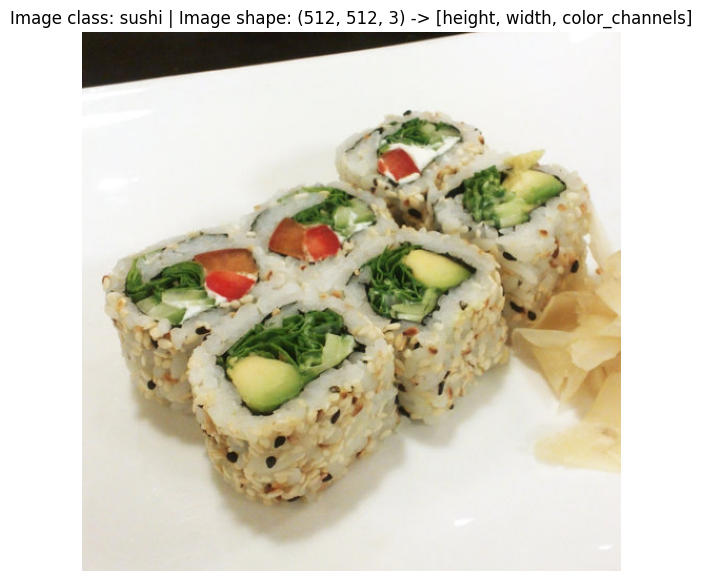

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);


# [CNN](https://poloclub.github.io/cnn-explainer/)

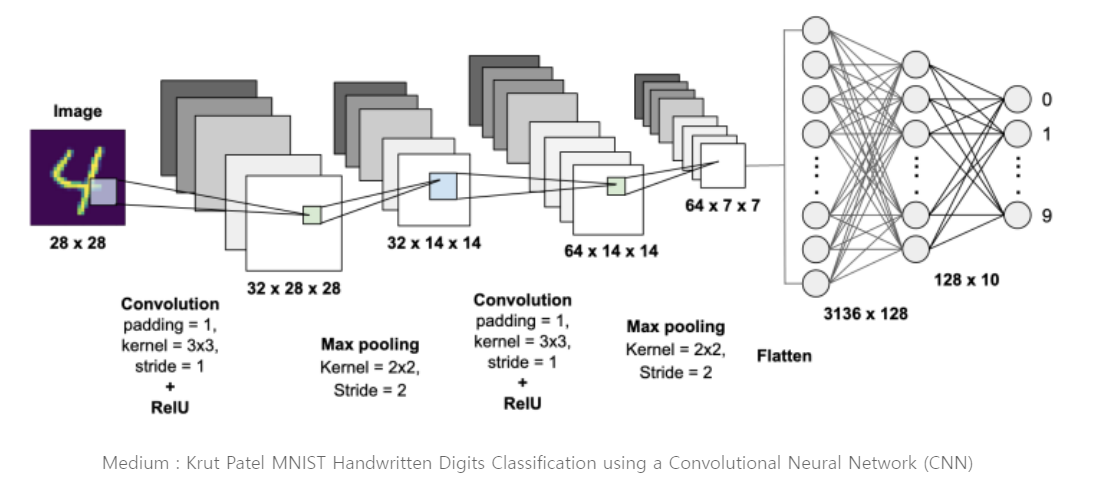

## CNN Layer

### [nn.Conv2d(in_channels, out_channels, kernel_size)](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md)  
- `stride`: controls the stride for the cross-correlation, a single number or a tuple.
- `padding`: controls the amount of padding applied to the input.
- `dilation`: controls the spacing between the kernel points


[output tensor size](https://velog.io/@tobigs1516_image/Convolutional-Neural-Networks):

- O: Size(width) of output image
- I: Size(width) of input image
- K: Size(width) of kernels used in the Conv layer
- N: Number of kernels
- S: Stride of the convolution operation
- P: Padding size  

$$
O = { I - K + 2P \over S } + 1
$$

In [18]:
# With square kernels and equal stride
m = nn.Conv2d(16, 33, 3, stride=2)
input = torch.randn(20, 16, 50, 100)
m(input).shape

torch.Size([20, 33, 24, 49])

In [19]:
# non-square kernels and unequal stride and with padding and dilation
m = nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2), dilation=(3, 1))
input = torch.randn(20, 16, 50, 100)
m(input).shape

torch.Size([20, 33, 26, 100])

### [nn.MaxPool2d()](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)
- `kernel_size`: the size of the window to take a max over
- `stride`: the stride of the window. Default value is `kernel_size`

In [20]:
# pool of square window of size=3, stride=2
m = nn.MaxPool2d(3, stride=2)
input = torch.randn(20, 16, 50, 32)
m(input).shape

torch.Size([20, 16, 24, 15])

In [21]:
# pool of non-square window
m = nn.MaxPool2d((3, 2), stride=(2, 1))
input = torch.randn(20, 16, 50, 32)
m(input).shape

torch.Size([20, 16, 24, 31])

## Dataset

In [22]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [23]:
# Load and transform data
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=simple_transform)


## DataLoader

In [24]:
# Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader = DataLoader(train_data,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader = DataLoader(test_data,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader, test_dataloader

Creating DataLoader's with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x78869398bd60>,
 <torch.utils.data.dataloader.DataLoader at 0x78869398bbb0>)

## CNN Model

In [25]:
# Create a convolutional neural network
class CNNModelV1(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3, # how big is the square that's going over the image?
                    stride=1, # default
                    padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                        out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [26]:
cnn_model = CNNModelV1(input_shape=3,
    hidden_units=10,
    output_shape=len(train_data.classes)).to(device)

cnn_model

CNNModelV1(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [27]:
# cnn model
torchinfo.summary(cnn_model,(32, 3, 64, 64), col_names=["kernel_size", "input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #
CNNModelV1                               --                        [32, 3, 64, 64]           [32, 3]                   --
├─Sequential: 1-1                        --                        [32, 3, 64, 64]           [32, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [3, 3]                    [32, 3, 64, 64]           [32, 10, 64, 64]          280
│    └─ReLU: 2-2                         --                        [32, 10, 64, 64]          [32, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [3, 3]                    [32, 10, 64, 64]          [32, 10, 64, 64]          910
│    └─ReLU: 2-4                         --                        [32, 10, 64, 64]          [32, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    2                         [32, 10, 64, 64]          [32, 10, 32, 32]          --
├─Sequential: 1-2

### Stepping through training of CNN Model

In [29]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))

In [30]:
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

- block_1

In [31]:
input_shape = 3
hidden_units = 10

block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3, # how big is the square that's going over the image?
                    stride=1, # default
                    padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                    stride=2) # default stride value is same as kernel_size
        )

In [32]:
train_features_batch.shape

torch.Size([32, 3, 64, 64])

In [33]:
# x = self.block_1(x)
block_1_out = block_1(train_features_batch)
block_1_out.shape

torch.Size([32, 10, 32, 32])

- block_2

In [34]:
block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

In [35]:
# x = self.block_2(x)
block_2_out = block_2(block_1_out)
block_2_out.shape

torch.Size([32, 10, 16, 16])

- classifier

In [36]:
output_shape = len(train_data.classes)

classifier = nn.Sequential(
                nn.Flatten(),
                # Where did this in_features shape come from?
                # It's because each layer of our network compresses and changes the shape of our inputs data.
                nn.Linear(in_features=hidden_units*16*16,
                        out_features=output_shape)
            )

In [37]:
# x = self.classifier(x)
out = classifier(block_2_out)
out.shape

torch.Size([32, 3])

## Training

In [38]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=cnn_model.parameters(),
                            lr=0.1)

In [39]:
torch.manual_seed(SEED)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=cnn_model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=cnn_model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_cnn_model = print_train_time(start=train_time_start_model_2,
                                                end=train_time_end_model_2,
                                                device=device)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.09968 | Train accuracy: 37.89%
Test loss: 1.23366 | Test accuracy: 26.04%

Epoch: 1
---------
Train loss: 1.10432 | Train accuracy: 42.58%
Test loss: 1.14711 | Test accuracy: 26.04%

Epoch: 2
---------
Train loss: 1.09381 | Train accuracy: 42.58%
Test loss: 1.14190 | Test accuracy: 26.04%

Train time on cpu: 5.490 seconds


## Evaluate trained Model

In [40]:
# Get cnn_model results
cnn_model_results = eval_model(
    model=cnn_model,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

cnn_model_results

{'model_name': 'CNNModelV1',
 'model_loss': 1.1418973207473755,
 'model_acc': 26.041666666666668}

# CNN with Data Augmentation

## Create transform with Data Augmentation

In [41]:
sample_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [42]:
# Turn image folders into Datasets
sample_dataset = datasets.ImageFolder(train_dir, transform=sample_transform)
sample_dataset

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [43]:
def calculate_norm(dataset):
    # dataset의 axis=1, 2에 대한 평균 산출
    mean_ = np.array([np.mean(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 평균 산출
    mean_r = mean_[:, 0].mean()
    mean_g = mean_[:, 1].mean()
    mean_b = mean_[:, 2].mean()

    # dataset의 axis=1, 2에 대한 표준편차 산출
    std_ = np.array([np.std(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 표준편차 산출
    std_r = std_[:, 0].mean()
    std_g = std_[:, 1].mean()
    std_b = std_[:, 2].mean()

    return (mean_r, mean_g, mean_b), (std_r, std_g, std_b)

In [44]:
mean_, std_ = calculate_norm(sample_dataset)
print(f'평균(R,G,B): {mean_}\n표준편차(R,G,B): {std_}')

평균(R,G,B): (0.5354544, 0.41756177, 0.3301338)
표준편차(R,G,B): (0.22768107, 0.22967243, 0.21931246)


In [45]:
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean_, std_)
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean_, std_)
])

## Dataset

In [46]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
                Normalize(mean=(0.5354544, 0.41756177, 0.3301338), std=(0.22768107, 0.22967243, 0.21931246))
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
                Normalize(mean=(0.5354544, 0.41756177, 0.3301338), std=(0.22768107, 0.22967243, 0.21931246))
            ))

## DataLoader

In [47]:
# Turn Datasets into DataLoader's
import os

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x788688a22290>,
 <torch.utils.data.dataloader.DataLoader at 0x788688a22320>)

## CNN Model

In [48]:
# Create a convolutional neural network
class CNNModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3, # how big is the square that's going over the image?
                    stride=1, # default
                    padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                        out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [49]:
cnn_model_augmented = CNNModelV2(input_shape=3,
    hidden_units=10,
    output_shape=len(train_data.classes)).to(device)

cnn_model_augmented

CNNModelV2(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

## Training

In [50]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=cnn_model.parameters(),
                            lr=0.1)

In [51]:
torch.manual_seed(SEED)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader_augmented,
        model=cnn_model_augmented,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=cnn_model_augmented,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_cnn_model_augmented = print_train_time(start=train_time_start_model_2,
                                                end=train_time_end_model_2,
                                                device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.09398 | Train accuracy: 42.58%
Test loss: 1.10963 | Test accuracy: 29.17%

Epoch: 1
---------
Train loss: 1.09809 | Train accuracy: 30.47%
Test loss: 1.10963 | Test accuracy: 29.17%

Epoch: 2
---------
Train loss: 1.09669 | Train accuracy: 42.58%
Test loss: 1.10963 | Test accuracy: 29.17%

Train time on cpu: 5.735 seconds


## Evaluate trained Model

In [52]:
# Get cnn_model results
cnn_model_results_augmented = eval_model(
    model=cnn_model_augmented,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

cnn_model_results_augmented

{'model_name': 'CNNModelV2',
 'model_loss': 1.1096256971359253,
 'model_acc': 29.166666666666668}

# Compare model results

In [53]:
import pandas as pd

compare_results = pd.DataFrame([cnn_model_results, cnn_model_results_augmented])
compare_results

,model_name,model_loss,model_acc
0,CNNModelV1,1.141897,26.041667
1,CNNModelV2,1.109626,29.166667


In [54]:
# Add training times to results comparison
compare_results["training_time"] = [total_train_time_cnn_model,
                                    total_train_time_cnn_model_augmented]
compare_results

,model_name,model_loss,model_acc,training_time
0,CNNModelV1,1.141897,26.041667,5.489903
1,CNNModelV2,1.109626,29.166667,5.735361


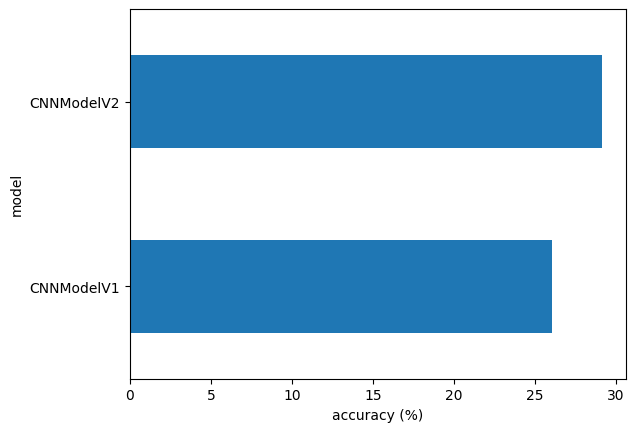

In [55]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");